In [1]:
import optuna
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy

# Define o ambiente Gym
env_name = 'CartPole-v1'
env = Monitor(gym.make(env_name))

# Função de avaliação
def evaluate(trial):
    model_params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'n_steps': 2048,
        'batch_size': trial.suggest_categorical("batch_size", [16, 32, 64, 128]),
        'n_epochs': trial.suggest_categorical('n_epochs', [5, 10, 20]),
        'gamma': trial.suggest_float('gamma', 0.9, 0.999),
        'gae_lambda': trial.suggest_float('gae_lambda', 0.8, 0.99),
        'clip_range': trial.suggest_float('clip_range', 0.1, 0.4),
        'normalize_advantage': trial.suggest_categorical('normalize_advantage', [True, False]),
        'ent_coef': trial.suggest_float('ent_coef', 0.0, 0.1),
        'vf_coef': trial.suggest_float('vf_coef', 0.1, 0.9),
        'max_grad_norm': trial.suggest_float('max_grad_norm', 0.3, 10.0),
        'target_kl': trial.suggest_float('target_kl', 0.01, 0.5)
    }
    
    # Criação do modelo PPO
    model = PPO('MlpPolicy', env, verbose=0, **model_params)
    
    # Treinamento do modelo
    model.learn(total_timesteps=1000)  # Ajuste o número de etapas conforme necessário

    eval_env = Monitor(gym.make(env_name))

    # Avaliação do modelo
    mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=10)

    return mean_reward

class CheckHyperparamMeanRewardThreshold:
    def __init__(self, reward_threshold: float):
        self.reward_threshold = reward_threshold

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial) -> None:
        if trial.value is not None and trial.value >= self.reward_threshold:
            print((f'Stopping hyperparameter search because trial.value ({trial.value}) '
                   f'hit threshold ({self.reward_threshold})'))
            study.stop()


In [2]:
import numpy as np

# Define o estudo Optuna
study = optuna.create_study(direction='maximize')
study.optimize(evaluate, n_trials=50, callbacks=[CheckHyperparamMeanRewardThreshold(500.0)], show_progress_bar=True)

# Obtém os melhores hiperparâmetros
best_model_params = {**study.best_params}

# Criação do modelo com os melhores hiperparâmetros
best_model = PPO('MlpPolicy', env, **best_model_params)

# Envolve o ambiente de treinamento com Monitor
train_env = gym.make(env_name)

[I 2024-02-16 09:14:58,943] A new study created in memory with name: no-name-465a4553-35a8-437b-9b9f-3e01ebd0de5f


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-02-16 09:15:02,993] Trial 0 finished with value: 29.3 and parameters: {'learning_rate': 0.00018020452982599717, 'batch_size': 64, 'n_epochs': 20, 'gamma': 0.9141517281087741, 'gae_lambda': 0.8751375544648561, 'clip_range': 0.23251656175628535, 'normalize_advantage': False, 'ent_coef': 0.019695771830541442, 'vf_coef': 0.4757651631287215, 'max_grad_norm': 2.049436981432554, 'use_sde': False, 'sde_sample_freq': 8, 'target_kl': 0.13949432795559313}. Best is trial 0 with value: 29.3.
[W 2024-02-16 09:15:02,998] Trial 1 failed with parameters: {'learning_rate': 0.010854163141777841, 'batch_size': 128, 'n_epochs': 10, 'gamma': 0.9648876430492294, 'gae_lambda': 0.8333793698058731, 'clip_range': 0.2273312109836808, 'normalize_advantage': False, 'ent_coef': 0.05967786030409433, 'vf_coef': 0.21550714189863784, 'max_grad_norm': 7.534826737358313, 'use_sde': True, 'sde_sample_freq': 4, 'target_kl': 0.3828265793677573} because of the following error: ValueError('generalized State-Dependent E

ValueError: generalized State-Dependent Exploration (gSDE) can only be used with continuous actions.

In [ ]:
# Treinamento do modelo final
best_model.learn(total_timesteps=int(1e6), log_interval=1, progress_bar=True)  # Ajuste o número de etapas conforme necessário

# Avaliação do modelo final
eval_env = Monitor(gym.make(env_name))
eval_rewards, _ = evaluate_policy(best_model, eval_env, n_eval_episodes=1000, return_episode_rewards=True)


Output()

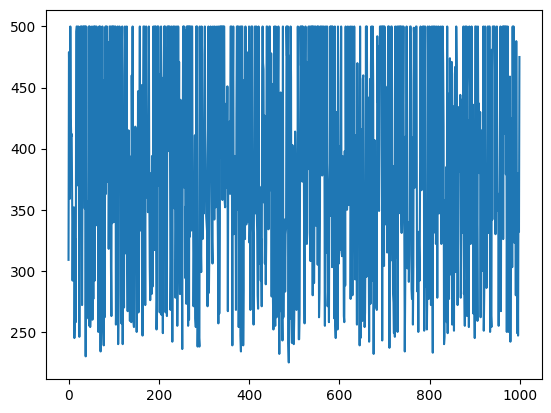

In [ ]:
import matplotlib.pyplot as plt
rewards = np.array(eval_rewards)
plt.plot(rewards)
plt.show()

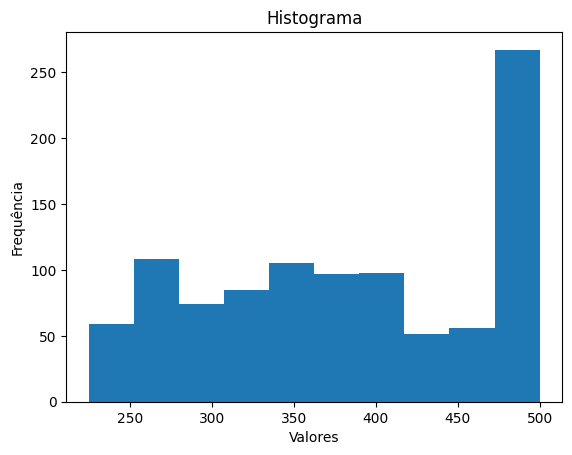

In [ ]:
plt.hist(rewards)
plt.title('Histograma')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.show()